In [18]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path)

import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from datasets import load_dataset

#force reimport
if 'pygents.aigents_api' in sys.modules:
    del sys.modules['pygents.aigents_api']
if 'pygents.plot' in sys.modules:
    del sys.modules['pygents.plot']
if 'pygents.util' in sys.modules:
    del sys.modules['pygents.util']

from pygents.aigents_api import TextMetrics, load_ngrams, punct, tokenize_re, build_ngrams, Learner
from pygents.plot import plot_dict, plot_dict_bars, matrix_plot
from pygents.util import dictcount, contains_seq

test_path = './temp/test/'

[nltk_data] Downloading package punkt to /Users/akolonin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
class Learner:

    def __init__(self):       
        self.labels = defaultdict(int) # A dictionary of label/category counts
        
        # Creating dictionaries for counting n-grams
        self.n_gram_dicts = defaultdict(lambda: defaultdict(int)) # A dictionary for each label/category
        self.all_n_grams = defaultdict(int)  # A general dictionary for all n-grams
        self.doc_counts = defaultdict(int)

        self.uniq_n_gram_dicts = defaultdict(lambda: defaultdict(int)) # Counts of uniq N-grams by label/category
        self.uniq_all_n_grams = defaultdict(int)  # A general dictionary for all n-grams uniq by text
        self.n_gram_labels = defaultdict(lambda: defaultdict(int)) # Counts of labels/categories by N-gram
    
    def count_labels(self,labels):
        for label in labels:
            dictcount(self.labels,label)

    def count_ngrams(self,labels,n_grams):
        dictcount(self.all_n_grams, n_grams)
        for label in labels:
            #print('dict=',self.n_gram_dicts[label],'label=',label)
            dictcount(self.n_gram_dicts[label], n_grams)  # Increment the counter for the corresponding label/category

        uniq_n_grams = set(n_grams)
        for uniq_n_gram in uniq_n_grams:
            self.doc_counts[uniq_n_gram] += 1
            dictcount(self.uniq_all_n_grams, uniq_n_gram)
            for label in labels:
                dictcount(self.uniq_n_gram_dicts[label], uniq_n_gram)
                dictcount(self.n_gram_labels[uniq_n_gram],label)

    def normalize(self):
        self.metrics = {}
        self.metrics['FN'] = dictdict_div_dict(self.n_gram_dicts,self.all_n_grams)
        # FN (alternative computation)
        #self.norm_n_gram_dicts = {}
        #for n_gram_dict in self.n_gram_dicts:
        #    norm_n_gram_dict = {}
        #    self.norm_n_gram_dicts[n_gram_dict] = norm_n_gram_dict
        #    dic = self.n_gram_dicts[n_gram_dict]
        #    for n_gram in dic:
        #        norm_n_gram_dict[n_gram] = float( dic[n_gram] ) / self.all_n_grams[n_gram]
        #TODO : 
        #selection_metrics = {
        #    'F':frequency,
        #    'UF':unique_frequency,
        #    'FN':frequency_self_normalized,
        #    'UFN':unique_frequency_self_normalized,
        #    'UFN/D/D':norm_uniq_n_gram_dicts,
        #    'FN*UFN':norm_norm_uniq,
        #    'FN*UFN/D':norm_norm_uniq_norm,
        #    'CFR':cfr,
        #    'FCR':fcr,
        #    'MR':mr,
        #    'NLMI':nl_mi}        
    
    def export(self,metric='FN',inclusion_threshold=50):
        return dict_of_dicts_compress_by_threshold(self.metrics[metric],inclusion_threshold)

    def save(self,path,name,metric='FN',inclusion_threshold=50):
        model = self.export(metric=metric,inclusion_threshold=inclusion_threshold)        
        if not os.path.exists(path):
            os.makedirs(path)
        path += '/'+name
        if not os.path.exists(path):
            os.makedirs(path)  
        for label, ngrams in model.items():
            label_name = label # label.replace(" ", "_")
            file_path = f"{path}/{label_name}.txt"
            sorted_ngrams = sorted(ngrams.items(), key=lambda x: x[1], reverse=True)
            with open(file_path, "w", encoding="utf-8") as f:
                for ngram, metric_value in sorted_ngrams:
                    ngram_str = ' '.join(ngram)
                    f.write(f"{ngram_str}\t{metric_value}\n")
        
    def learn_sentence(self, text, labels, n_max=4, tokenize = tokenize_re, punctuation = None, debug = False):
        tokens = [t for t in tokenize(text) if not (t in punctuation or t.isnumeric())] if not punctuation is None else tokenize(text)
        for n in range(1, n_max + 1):
            n_grams = build_ngrams(tokens, n)
            self.count_ngrams(labels,n_grams)

    def learn(self, text_labels, n_max=4, tokenize = tokenize_re, punctuation = None, sent=False, debug = False):
        for text_label in text_labels:
            text = text_label[0]
            labels = text_label[1]
            if debug:
                print(text,labels)
            self.count_labels(labels)
            if sent:
                sentences = nltk.sent_tokenize(text) # this gives us a list of sentences
                if debug:
                    print(sentences)
                for sentence in sentences: # now loop over each sentence and learn it separately
                    self.learn_sentence(sentence, labels, n_max, tokenize, punctuation, debug)    
            else:
                self.learn_sentence(text, labels, n_max, tokenize, punctuation, debug)

        self.normalize()
        return self


In [10]:
all_metrics = ['All-or-nothing_thinking','Fortune-telling','Mental_filter','Overgeneralization','Labeling',
          'Mind_Reading','Personalization','Emotional_Reasoning','Magnification','Should_statements']


def df2labeled(df,binary=False):
    data = []
    for _, row in df.iterrows():
        # Text identification: first, check the 2nd column; if NaN, take the text from the 1st column
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        if not binary:
            primary_distortion = row.iloc[2]  # The primary cognitive distortion from the 3rd column
            secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if present
        else:
            primary_distortion = 'Distortion' if row.iloc[2] != 'No Distortion' else 'No Distortion'
            secondary_distortion = None
        cats = (primary_distortion,) if secondary_distortion is None else (primary_distortion,secondary_distortion)
        data.append((text, tuple([c.replace(' ','_') for c in cats])))
    return data

def language_metrics(lang,metrics_list,path):
    metrics = {}
    for m in metrics_list:
        metrics[m] = path + lang + '/' + m + '.txt'
    return metrics

def our_evaluator_test(all_metrics,expected_distortions,text,threshold):
    dic = {}
    for m in all_metrics:
        dic[m] = True if (m in expected_distortions) else False
    return dic

def our_evaluator_tm(all_metrics,tm,text,threshold):
    metrics = tm.get_sentiment_words(text)
    dic = {}
    for m in all_metrics:
        dic[m] = True if m in metrics and metrics[m] > threshold else False
    return dic

def our_evaluator_true(all_metrics,tm,text,threshold):
    dic = {}
    for m in all_metrics:
        dic[m] = True
    return dic
    
def our_evaluator_false(all_metrics,tm,text,threshold):
    dic = {}
    for m in all_metrics:
        dic[m] = False
    return dic

def our_evaluator_random(all_metrics,tm,text,threshold):
    dic = {}
    for m in all_metrics:
        dic[m] = random.choice([True, False])
    return dic

def dictval(dic,key,val):
    return dic[key] if key in dic else val 

def pre_rec_f1_from_counts(true_positive, true_negative, false_positive, false_negative):
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    return precision, recall, 2 * precision * recall / (precision + recall) if precision > 0 or recall > 0 else 0 

def evaluate_tm_df(df,tm,evaluator,threshold,all_metrics,debug=False):
    true_positives = {}
    true_negatives = {}
    false_positives = {}
    false_negatives = {}
    pre = {}
    rec = {}
    f1 = {}
    acc = {}
    for _, row in df.iterrows():
        # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else 'No Distortion'  # The secondary distortion from the 4th column, if it exists
        ground_distortions = []
        if primary_distortion != 'No Distortion':
            ground_distortions.append(primary_distortion.replace(' ','_'))
        if secondary_distortion != 'No Distortion':
            ground_distortions.append(secondary_distortion.replace(' ','_'))

        if evaluator == our_evaluator_test:
            distortions_by_metric = evaluator(all_metrics,ground_distortions,text,threshold) #hack to test metrics
        else:
            distortions_by_metric = evaluator(all_metrics,tm,text,threshold)

        if debug:
            print(ground_distortions,'=>',[m for m in distortions_by_metric if distortions_by_metric[m]])
        
        for metric in distortions_by_metric:
            our_distortion = distortions_by_metric[metric]
            if (metric in ground_distortions) and our_distortion == True:
                dictcount(true_positives,metric)
            if (not metric in ground_distortions) and our_distortion == True:
                dictcount(false_positives,metric)
            if (not metric in ground_distortions) and our_distortion == False:
                dictcount(true_negatives,metric)
            if (metric in ground_distortions) and our_distortion == False:
                dictcount(false_negatives,metric)

    if debug:
        #print()
        print('TP:',true_positives)
        print('FP:',false_positives)
        print('TN:',true_negatives)
        print('FN:',false_negatives)
    
    for metric in all_metrics:
        precision, recall, f1score = pre_rec_f1_from_counts(dictval(true_positives,metric,0), dictval(true_negatives,metric,0), 
                                   dictval(false_positives,metric,0), dictval(false_negatives,metric,0))
        pre[metric] = precision
        rec[metric] = recall
        f1[metric] = f1score
        acc[metric] = (dictval(true_positives,metric,0) + dictval(true_negatives,metric,0)) / len(df)
    
    return pre, rec, f1, acc


def full_test_circle(df, test_path, model_prefix, validation_fraction, inclusion_thresholds, detection_thresholds, all_scores = False):
    train_df = df[df.index % validation_fraction != 0]
    test_df = df[df.index % validation_fraction == 0]
    print(validation_fraction, len(df), len(train_df), len(test_df))

    learner=Learner()
    model = learner.learn(df2labeled(train_df), punctuation = punct, debug = False)
    print(model.labels)

    for inclusion_threshold in inclusion_thresholds:
        model.save(path=test_path,name=f'{model_prefix}-{inclusion_threshold}',metric='FN',inclusion_threshold=inclusion_threshold)
        all_metrics = sorted(model.export(metric='FN',inclusion_threshold=inclusion_threshold).keys() - {'No_Distortion'})
        tm = TextMetrics(language_metrics('',all_metrics,path=test_path+f'/{model_prefix}-{inclusion_threshold}'),encoding="utf-8",metric_logarithmic=True,debug=False)

        name = 'Multiclass FN'

        pres = [[] for i in range(len(all_metrics))]
        recs = [[] for i in range(len(all_metrics))]
        f1s = [[] for i in range(len(all_metrics))]
        accs = [[] for i in range(len(all_metrics))]

        for t in detection_thresholds:
            pre, rec, f1, acc = evaluate_tm_df(test_df,tm,our_evaluator_tm,t/100.0,all_metrics,debug=False)
            mi = 0
            for metric in all_metrics:
                pres[mi].append(pre[metric])
                recs[mi].append(rec[metric])
                f1s[mi].append(f1[metric])
                accs[mi].append(acc[metric])
                mi += 1

        if all_scores:
            matrix_plot(all_metrics, detection_thresholds, pres, 1.0, title = f'Precision: {name}, inclusion_threshold: {inclusion_threshold}', vmin = 0, vmax = 1.0, titlefontsize = 20, dpi = 200, width = 10)
            matrix_plot(all_metrics, detection_thresholds, recs, 1.0, title = f'Recall: {name}, inclusion_threshold: {inclusion_threshold}', vmin = 0, vmax = 1.0, titlefontsize = 20, dpi = 200, width = 10)
        matrix_plot(all_metrics, detection_thresholds, f1s, 1.0, title = f'F1: {name}, inclusion_threshold: {inclusion_threshold}', vmin = 0, vmax = 1.0, titlefontsize = 20, dpi = 200, width = 10)


In [11]:
ds = load_dataset(
    "halilbabacan/combined_synthetic_cognitive_distortions",
    split="train",
)

df = ds.to_pandas()
df = df.rename(columns={'text': 'Patient Question', 'label': 'Dominant Distortion'})
df.insert(1, 'Distorted part', value = np.nan)
df.insert(3, 'Secondary Distortion (Optional)', value = np.nan)
# Remove the row with index 738 because it contains a NaN in the text column
df = df.drop(index=738)


mapping = {
    "Labelling":            "Labeling",
    "Mental Filter":        "Mental filter",
    "Should Statements":    "Should statements",
    "All-or-Nothing Thinking": "All-or-nothing thinking"
}

df['Dominant Distortion'] = df['Dominant Distortion'].map(mapping).fillna(df['Dominant Distortion'])

df

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,John walked past me without saying a word He m...,NaN,Mind Reading,NaN
1,"During the meeting, Sarah didn't look at me on...",NaN,Mind Reading,NaN
2,Mike didn't respond to my text right away He m...,NaN,Mind Reading,NaN
3,Jessica didn't smile when she saw me She must ...,NaN,Mind Reading,NaN
4,Tom didn't invite me to his party He must not ...,NaN,Mind Reading,NaN
...,...,...,...,...
4526,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
4527,Now I am at university my peers around me all ...,NaN,Overgeneralization,NaN
4528,He claims he’s severely depressed and has outb...,NaN,Mental filter,NaN
4529,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


In [12]:
inclusion_thresholds = [10,30,50,70,80,90]
detection_thresholds = [10,30,50,70,80,90]


10 4530 4076 454
defaultdict(<class 'int'>, {'Mind_Reading': 401, 'Overgeneralization': 395, 'Magnification': 360, 'Labeling': 319, 'Personalization': 319, 'Fortune-telling': 306, 'Emotional_Reasoning': 303, 'Mental_filter': 292, 'Should_statements': 278, 'All-or-nothing_thinking': 264, 'No_Distortion': 839})


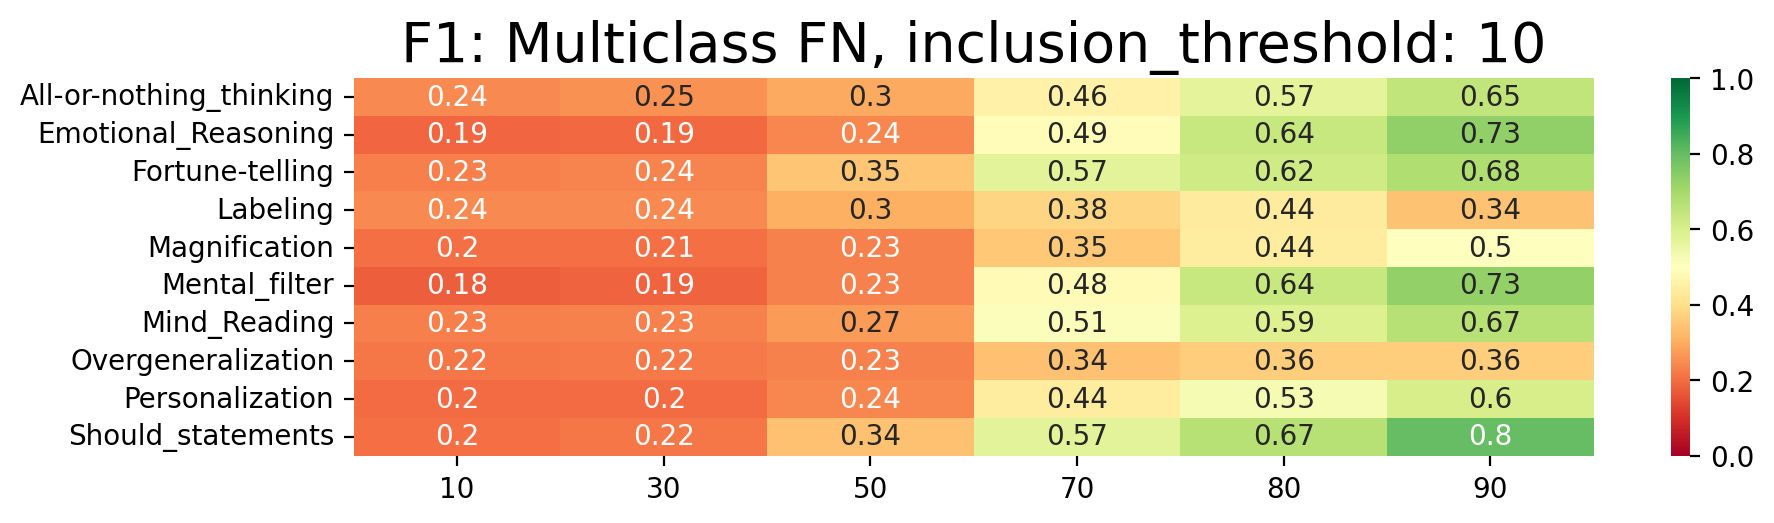

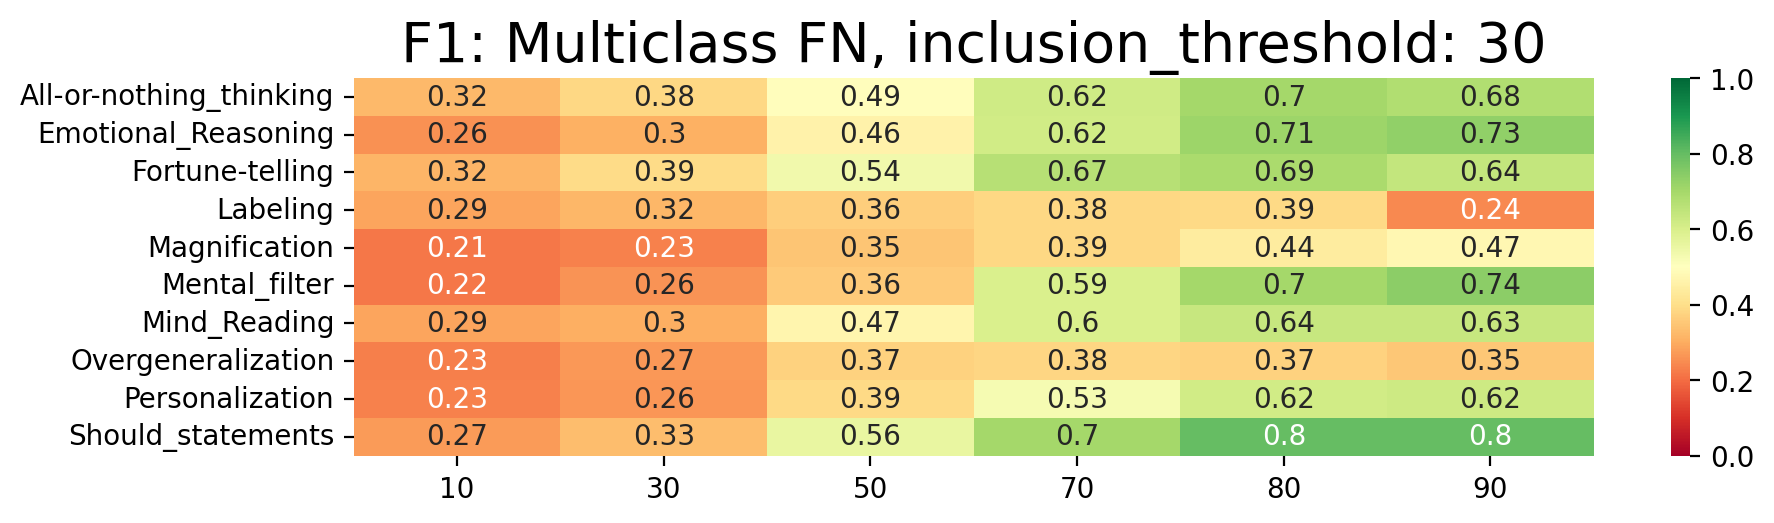

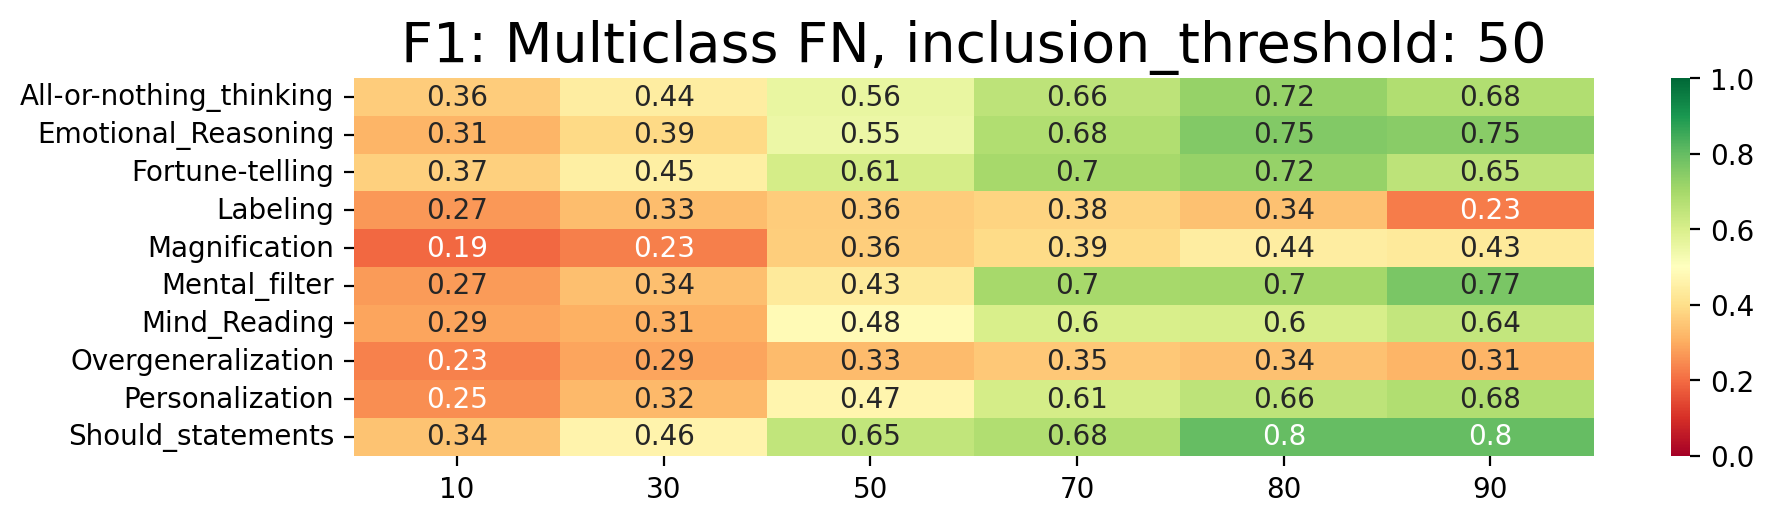

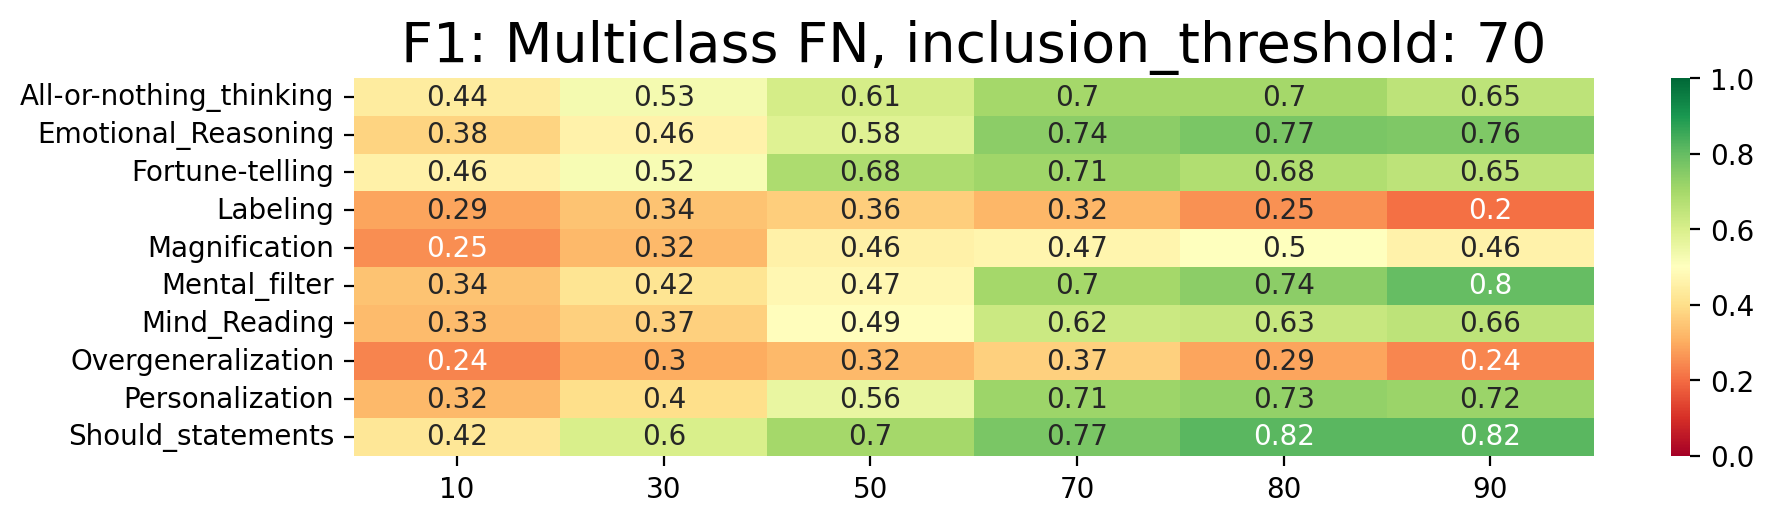

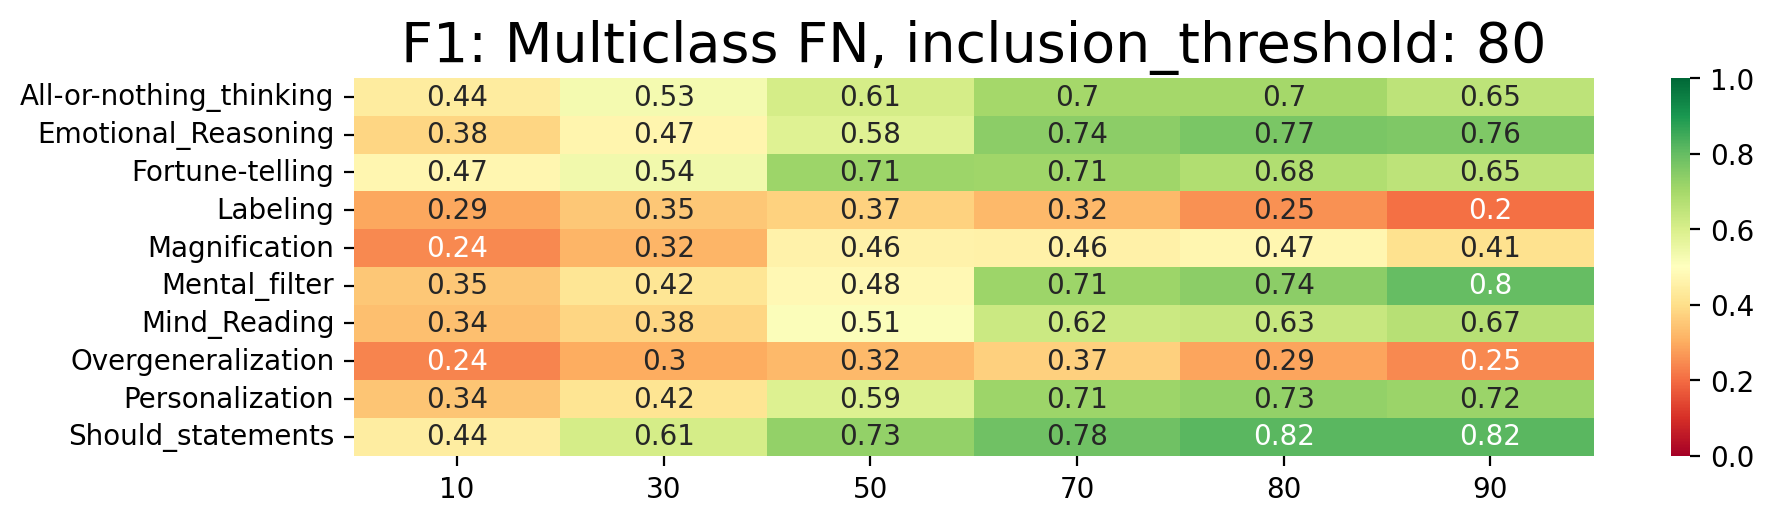

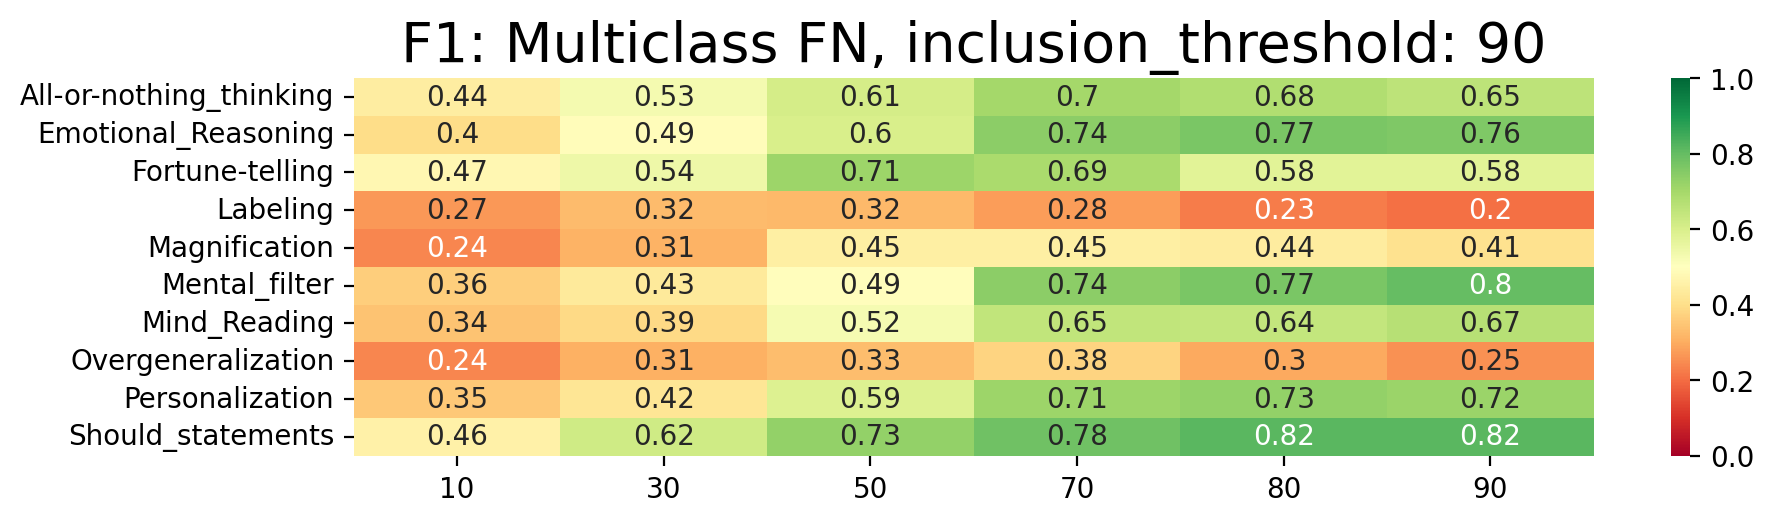

In [13]:
full_test_circle(df, test_path, 'multi-split-exp', 10, inclusion_thresholds, detection_thresholds)


10 4530 4076 454
defaultdict(<class 'int'>, {'Mind_Reading': 401, 'Overgeneralization': 395, 'Magnification': 360, 'Labeling': 319, 'Personalization': 319, 'Fortune-telling': 306, 'Emotional_Reasoning': 303, 'Mental_filter': 292, 'Should_statements': 278, 'All-or-nothing_thinking': 264, 'No_Distortion': 839})


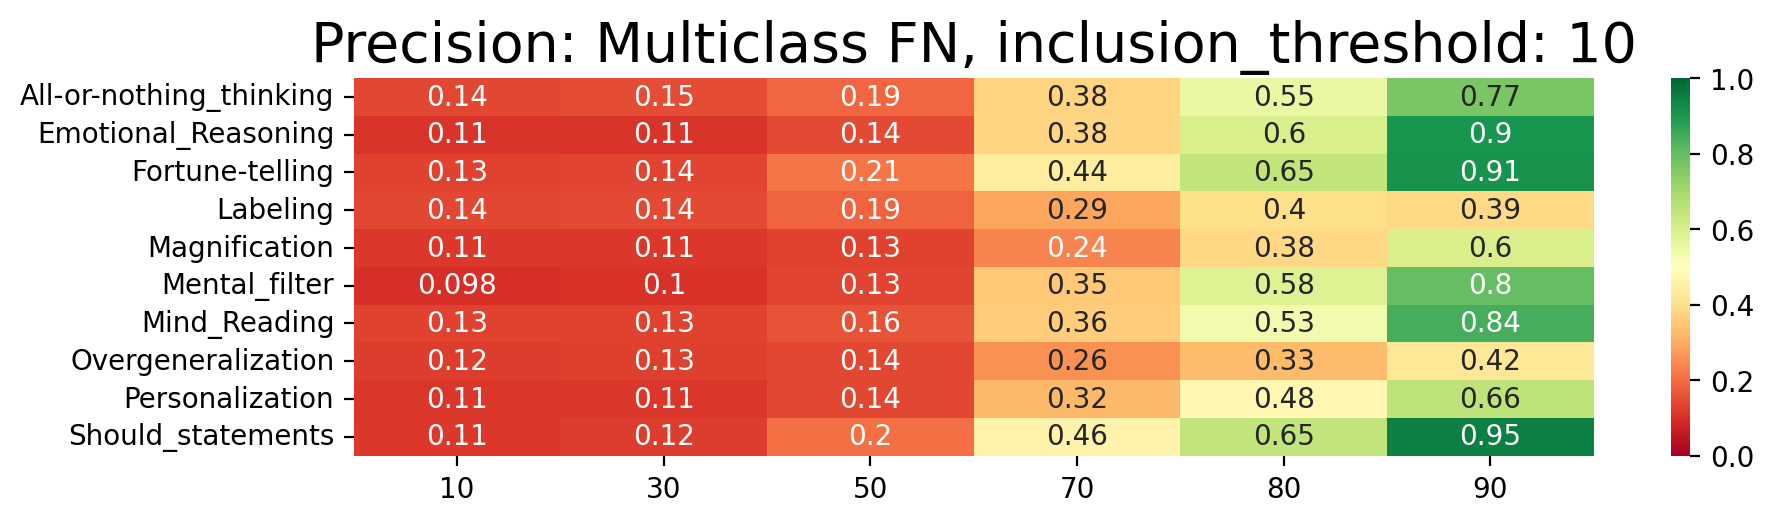

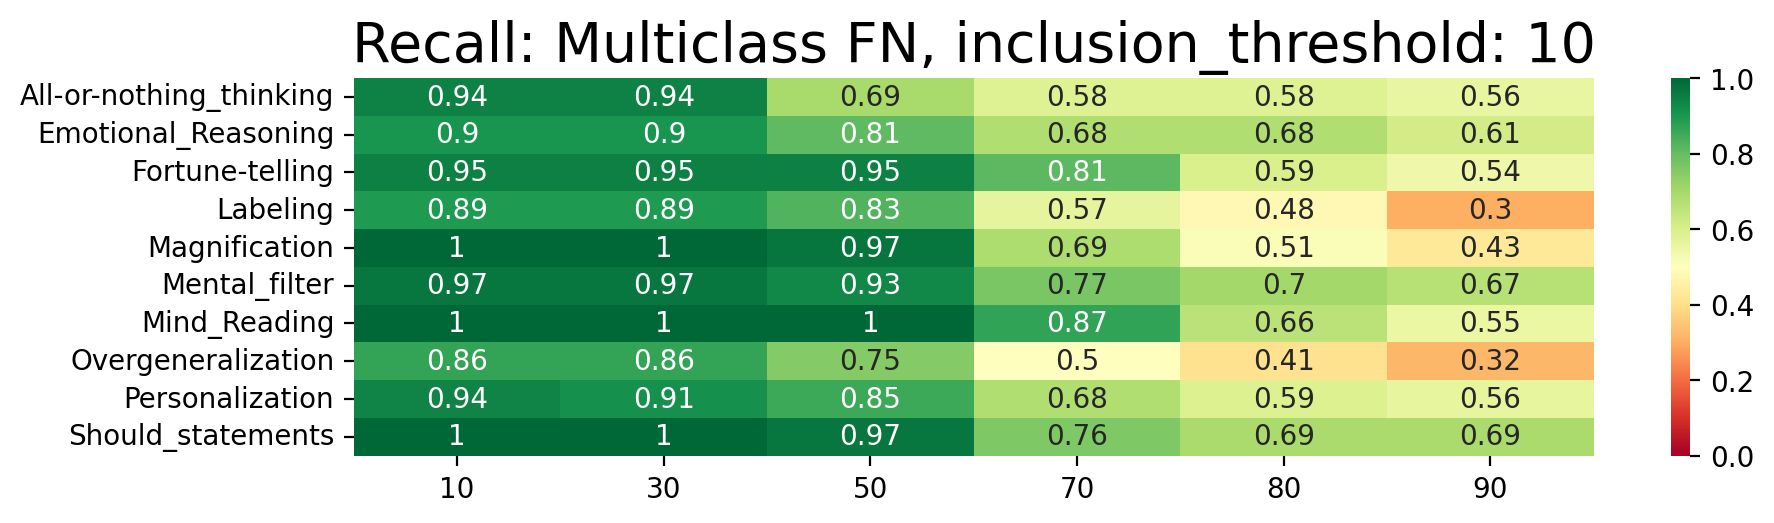

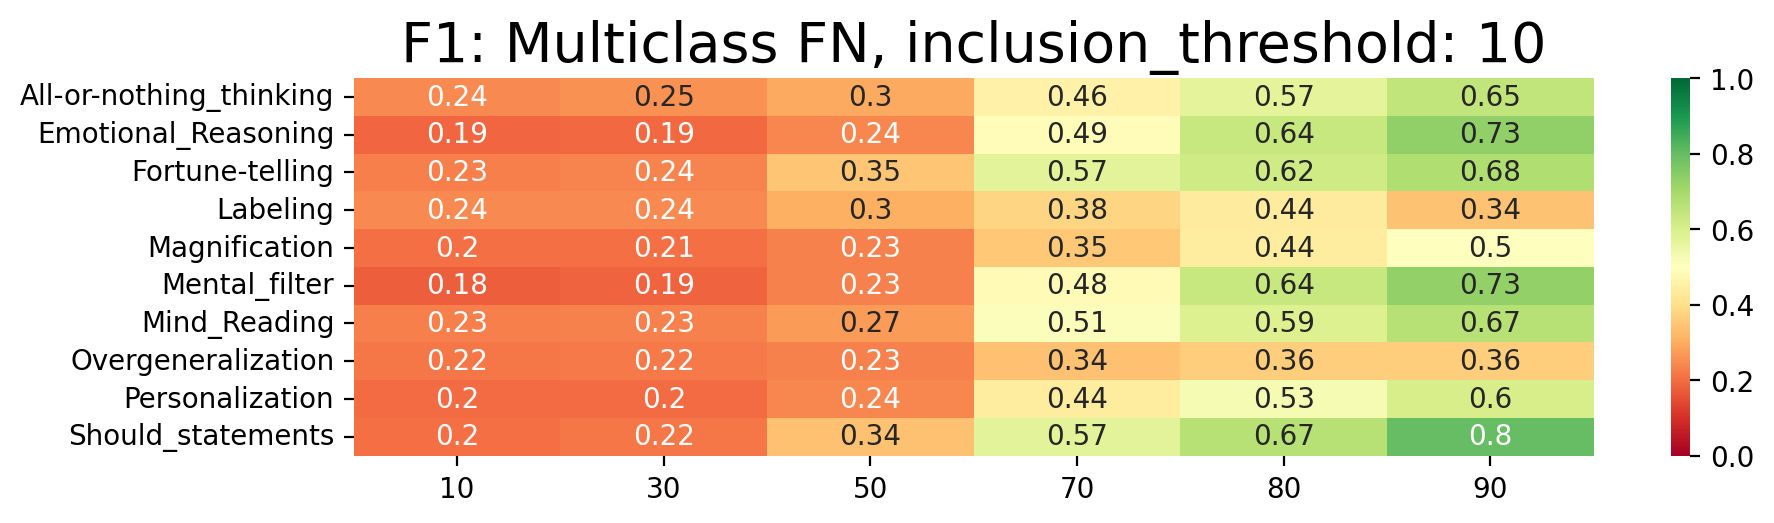

In [17]:
full_test_circle(df, test_path, 'multi-split-exp', 10, [10], detection_thresholds, all_scores = True)


10 4530 4076 454
defaultdict(<class 'int'>, {'Mind_Reading': 401, 'Overgeneralization': 395, 'Magnification': 360, 'Labeling': 319, 'Personalization': 319, 'Fortune-telling': 306, 'Emotional_Reasoning': 303, 'Mental_filter': 292, 'Should_statements': 278, 'All-or-nothing_thinking': 264, 'No_Distortion': 839})


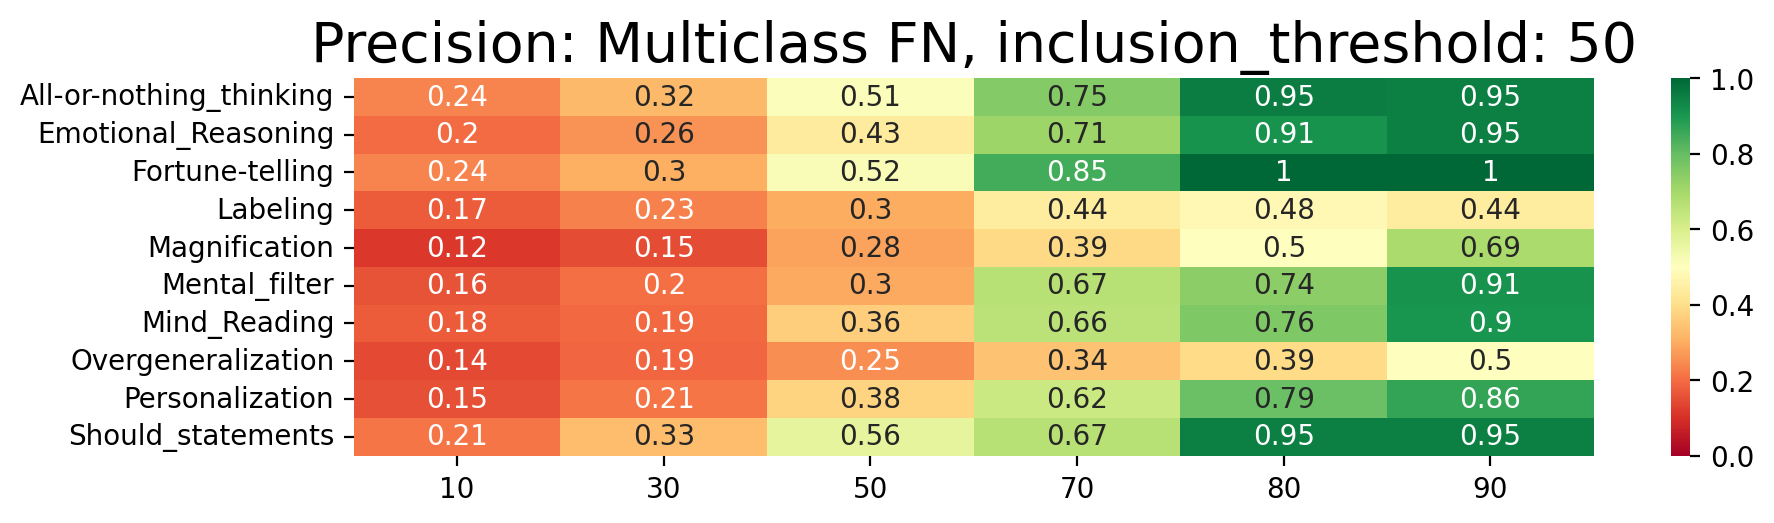

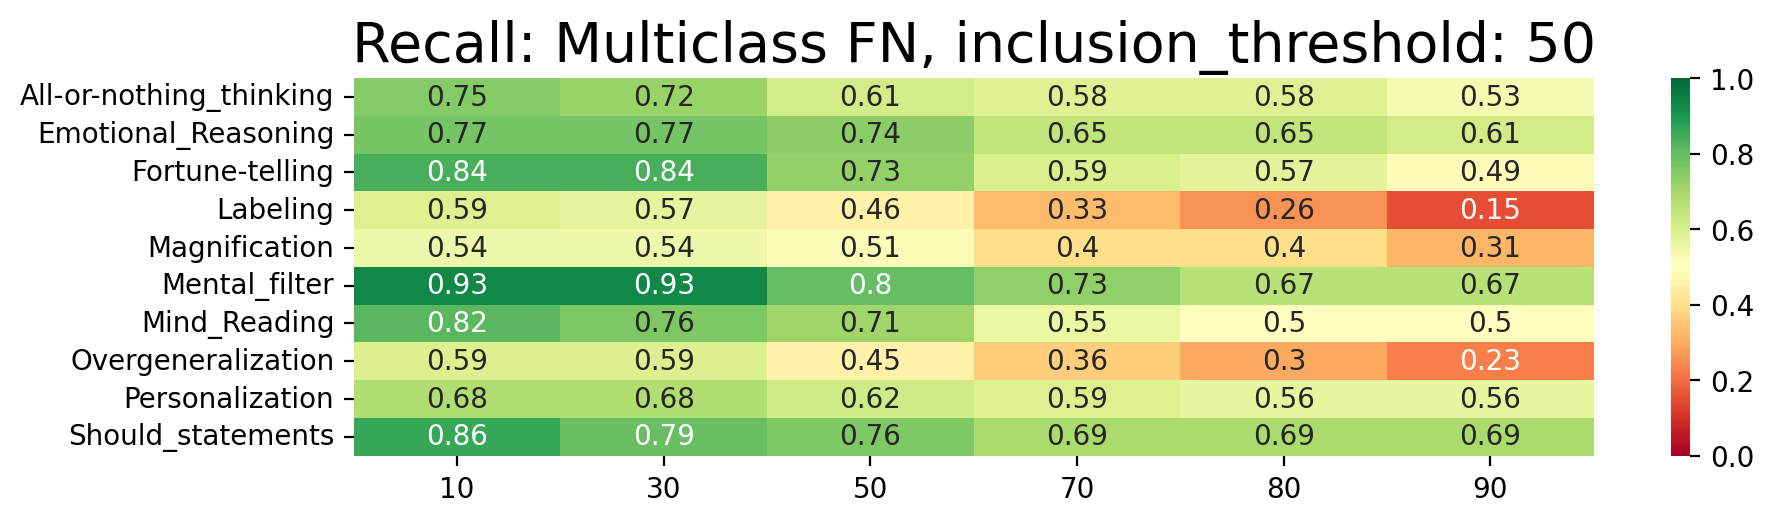

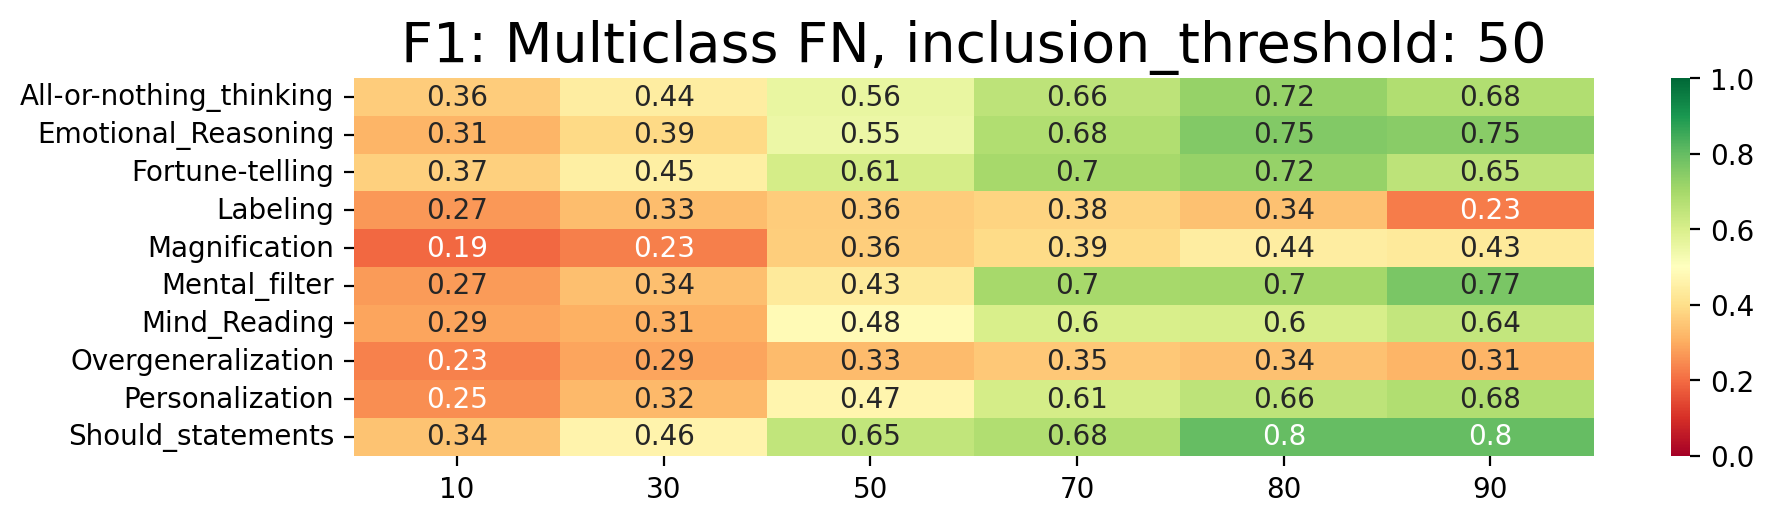

In [15]:
full_test_circle(df, test_path, 'multi-split-exp', 10, [50], detection_thresholds, all_scores = True)


10 4530 4076 454
defaultdict(<class 'int'>, {'Mind_Reading': 401, 'Overgeneralization': 395, 'Magnification': 360, 'Labeling': 319, 'Personalization': 319, 'Fortune-telling': 306, 'Emotional_Reasoning': 303, 'Mental_filter': 292, 'Should_statements': 278, 'All-or-nothing_thinking': 264, 'No_Distortion': 839})


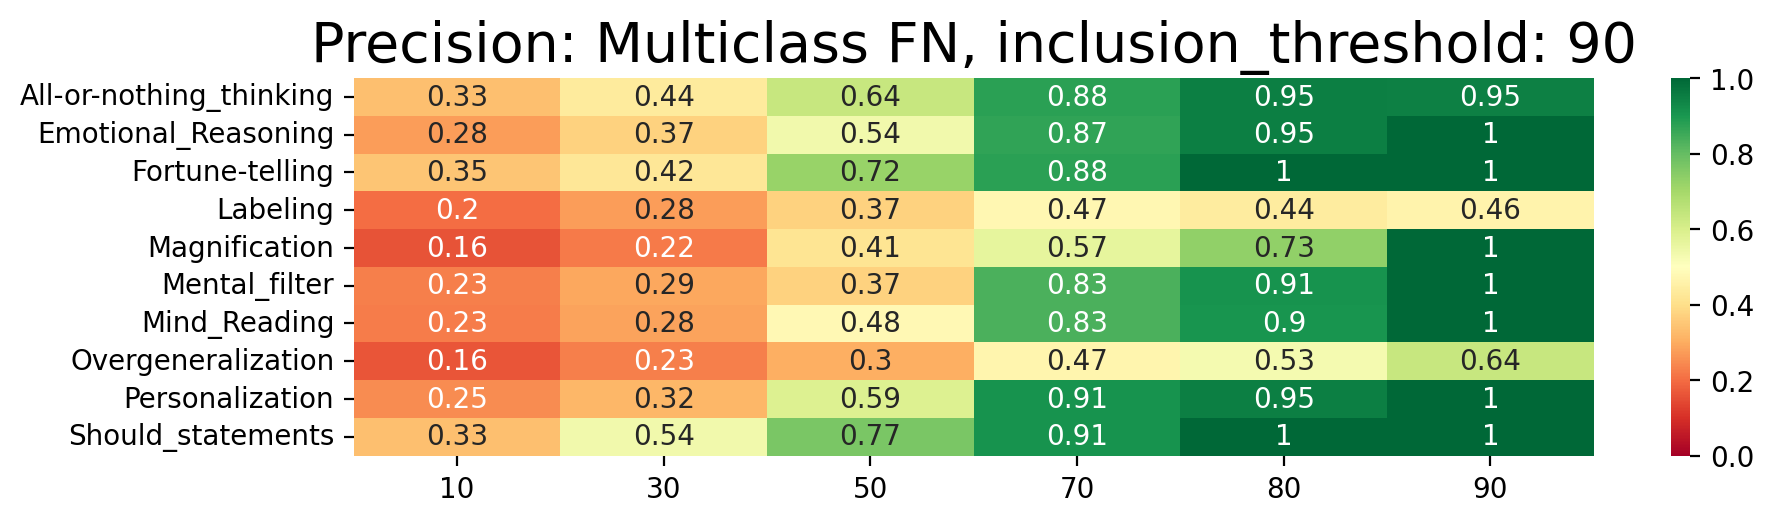

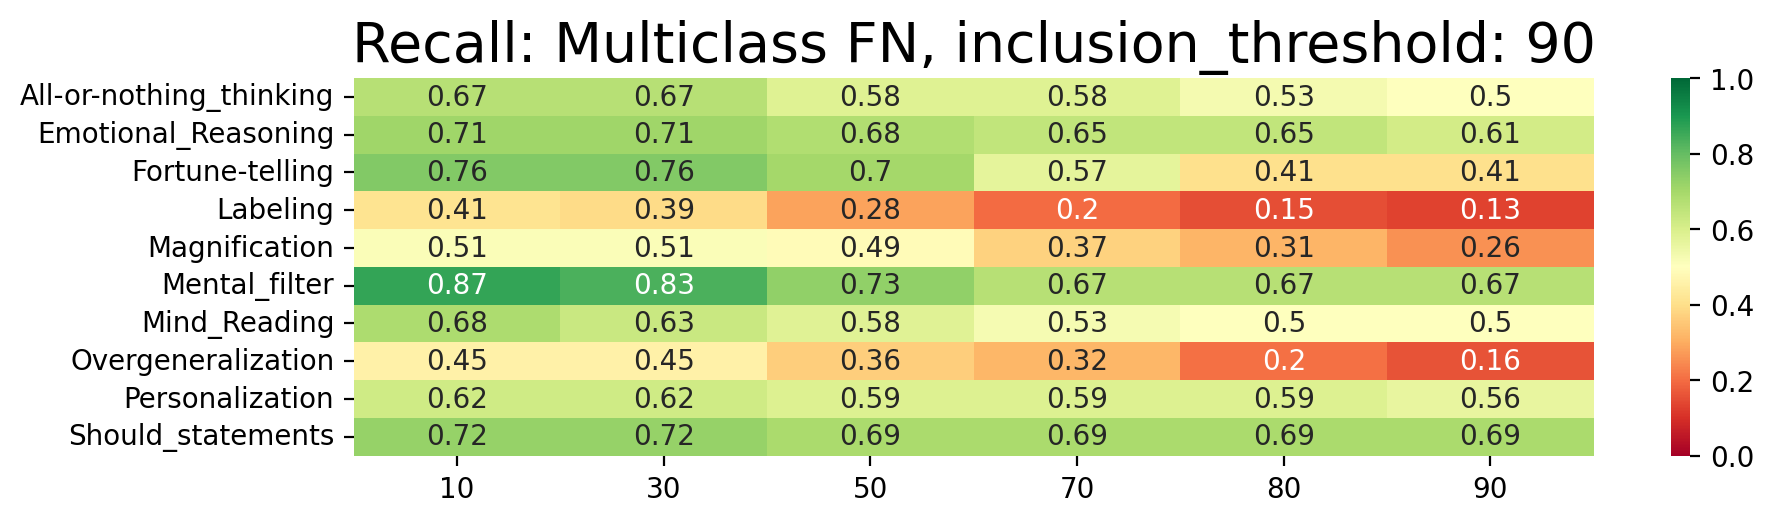

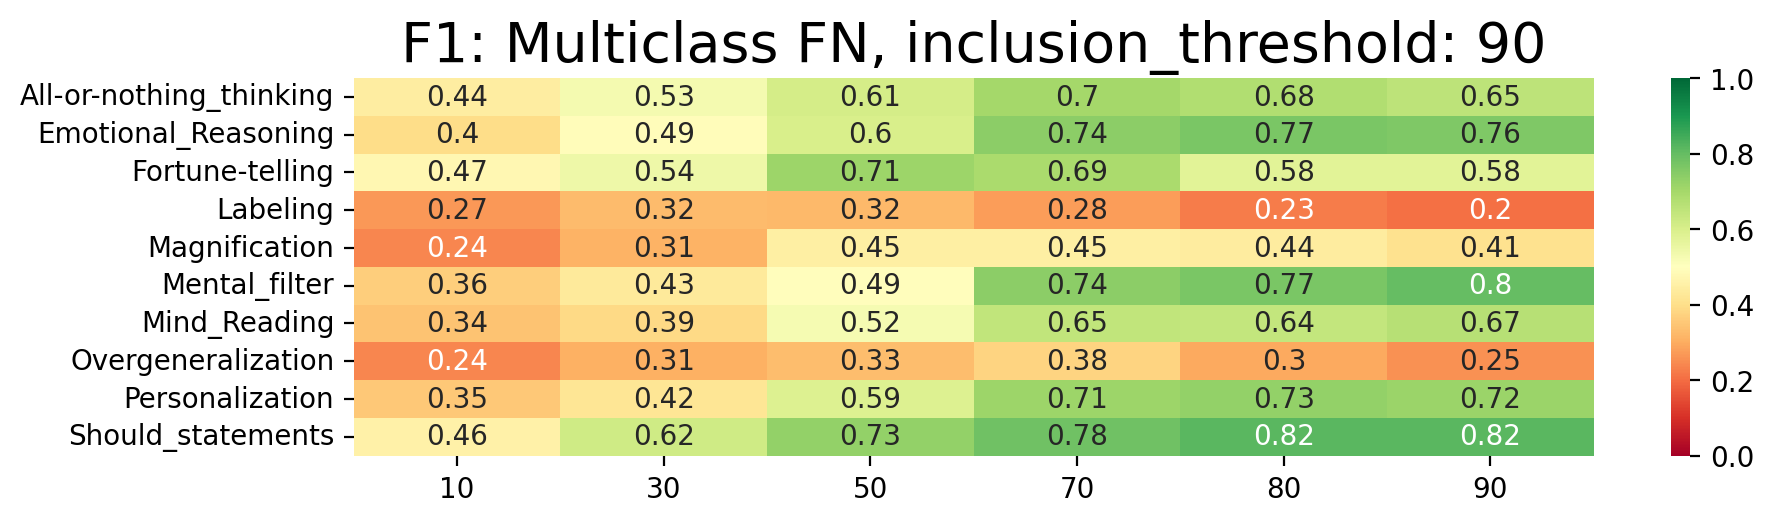

In [16]:
full_test_circle(df, test_path, 'multi-split-b2', 10, [90], detection_thresholds, all_scores = True)


In [23]:
inclusion_threshold = 50
print(inclusion_threshold)
tm = TextMetrics(language_metrics('',all_metrics,path=test_path+f'/multi-split-exp-{inclusion_threshold}'),encoding="utf-8",metric_logarithmic=True,debug=False)


50


In [24]:
[t for t in tm.metrics['Labeling'] if contains_seq(t, ("i'm", "so"))]

[('my', 'notes', "i'm", 'so'),
 ('follow', 'up', "i'm", 'so'),
 ('my', 'workout', "i'm", 'so'),
 ('bill', "i'm", 'so', 'irresponsible'),
 ("i'm", 'so', 'unproductive'),
 ('password', "i'm", 'so'),
 ('homework', "i'm", 'so', 'forgetful'),
 ('homework', "i'm", 'so'),
 ('the', 'conversation', "i'm", 'so'),
 ('diet', "i'm", 'so'),
 ('everyone', "i'm", 'so', 'clumsy'),
 ('email', "i'm", 'so', 'irresponsible'),
 ("i'm", 'so', 'unreliable'),
 ('time', "i'm", 'so', 'forgetful'),
 ('way', "i'm", 'so'),
 ('the', 'rent', "i'm", 'so'),
 ('appointment', 'time', "i'm", 'so'),
 ('participate', "i'm", 'so'),
 ("i'm", 'so', 'unprepared'),
 ('the', 'document', "i'm", 'so'),
 ('conversation', "i'm", 'so'),
 ('participate', "i'm", 'so', 'timid'),
 ('wallet', "i'm", 'so'),
 ('movie', "i'm", 'so'),
 ('notes', "i'm", 'so', 'forgetful'),
 ('the', 'card', "i'm", 'so'),
 ('pace', "i'm", 'so', 'slow'),
 ("i'm", 'so', 'irresponsible'),
 ('question', "i'm", 'so', 'dumb'),
 ('the', 'pace', "i'm", 'so'),
 ('the', 'r